#### Developing a function that allows us to do spatial CV on the training dataset.
Spatial autocorrolation means that we may get inflated test results if we perform normal CV on the data. <br>
To account for this, we perform cross validation on the models based on clustering. <br>
We test out CV on a per-neighbourhood basis, as well as CV based on K-Means clustering.

In [1]:
# Import 3rd party libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# Configure Notebook
%matplotlib inline
#plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')
#plt.style.use('ggplot')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

#### Insert code to get the testing data in, see the EDA files for the development of this code:

(59553, 13)


<AxesSubplot:>

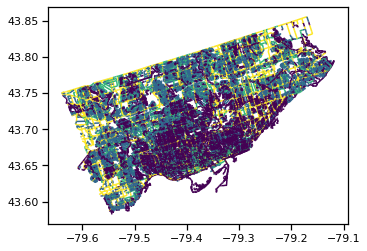

In [2]:
# import Bo's shapefile
file_path_keagan = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Bo Github Data/centerline_LTS_July2021.shp'
file_path_saad = 'insert here for ease'
lts_gpd = gpd.read_file(file_path_keagan)
lts_gpd['high access'] = lts_gpd['LTS'].apply(lambda x: 1 if x <= 2 else 0)
lts_gpd = lts_gpd[lts_gpd['LTS'] != 0]
print(lts_gpd.shape)
lts_gpd.plot(column='LTS')

In [3]:
# import the neighbourhood data
fp_k, fp_k2 = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Neighbourhood Data/neighbourhood-profiles-2016-csv (1).csv', \
              'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Neighbourhood Data/Neighbourhoods.geojson'
fp_s, fp_s2 = 'filepath1', 'filepath2'

neighbourhood_info = pd.read_csv(fp_k)
neighbourhood_boundaries = gpd.read_file(fp_k2)

In [4]:
neighbourhood_boundaries.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   _id                  140 non-null    int64   
 1   AREA_ID              140 non-null    int64   
 2   AREA_ATTR_ID         140 non-null    int64   
 3   PARENT_AREA_ID       0 non-null      object  
 4   AREA_SHORT_CODE      140 non-null    int64   
 5   AREA_LONG_CODE       140 non-null    int64   
 6   AREA_NAME            140 non-null    object  
 7   AREA_DESC            140 non-null    object  
 8   X                    0 non-null      object  
 9   Y                    0 non-null      object  
 10  LONGITUDE            0 non-null      object  
 11  LATITUDE             0 non-null      object  
 12  OBJECTID             140 non-null    int64   
 13  Shape__Area          140 non-null    float64 
 14  Shape__Length        140 non-null    float64 
 15  CLASSIFICATION 

In [5]:
# Try merging the Neighbourhood boundaries to the LTS data.
neighbourhood_metre = neighbourhood_boundaries.to_crs("EPSG:26917")
lts_metre = lts_gpd.to_crs("EPSG:26917")

neigh_merge = gpd.sjoin(lts_metre, #left
                       neighbourhood_metre, #right
                       how='left',
                       op='within',
                      )

neigh_merge.head()

,OBJECTID_left,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,...,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID_right,Shape__Area,Shape__Length,CLASSIFICATION,CLASSIFICATION_CODE
0,1,30079678,19155,Waterfront Trl,30079676,30079656,0,457.224811,30079678,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,30079680,19166,Marie Curtis Park Trl,30079676,30079679,0,35.226524,30079680,1,...,Long Branch (19),None,None,None,None,17546689.0,4.315294e+06,10782.626434,None,None
2,3,30079677,19155,Waterfront Trl,30008708,30079676,0,37.170074,30079677,1,...,Long Branch (19),None,None,None,None,17546689.0,4.315294e+06,10782.626434,None,None
3,4,30082310,10685,Island Rd,30008708,30082309,0,168.541328,30082310,1,...,Long Branch (19),None,None,None,None,17546689.0,4.315294e+06,10782.626434,None,None
4,5,30008940,19155,Waterfront Trl,30008711,30008708,0,84.289210,30008940,1,...,Long Branch (19),None,None,None,None,17546689.0,4.315294e+06,10782.626434,None,None


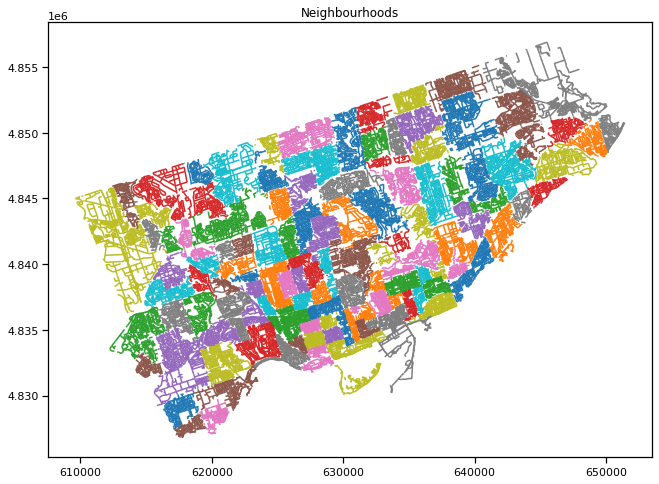

In [6]:
# Test out the merge by plotting
fig, axs = plt.subplots(figsize=(15,8),)

# Plotting
neigh_merge.plot(ax=axs, column='AREA_NAME')

# Attributes
axs.title.set_text('Neighbourhoods')

In [7]:
neigh_merge = neigh_merge[['GEO_ID','LTS','high access','geometry','AREA_NAME', 'AREA_ID']]
neigh_merge['AREA_NAME'] = neigh_merge['AREA_NAME'].fillna('None')
neigh_merge['AREA_ID'] = neigh_merge['AREA_ID'].fillna(101)
neigh_merge.head()

,GEO_ID,LTS,high access,geometry,AREA_NAME,AREA_ID
0,30079678,1,1,"LINESTRING (617480.231 4826902.149, 617480.138...",None,101.0
1,30079680,1,1,"LINESTRING (617480.231 4826902.149, 617476.262...",Long Branch (19),2480159.0
2,30079677,1,1,"LINESTRING (617498.783 4826933.578, 617490.916...",Long Branch (19),2480159.0
3,30082310,1,1,"LINESTRING (617498.783 4826933.578, 617516.356...",Long Branch (19),2480159.0
4,30008940,1,1,"LINESTRING (617552.625 4826998.137, 617541.914...",Long Branch (19),2480159.0


In [8]:
neigh_merge.shape

(59553, 6)

In [9]:
neigh_merge['AREA_NAME'].unique().shape

(141,)

<AxesSubplot:>

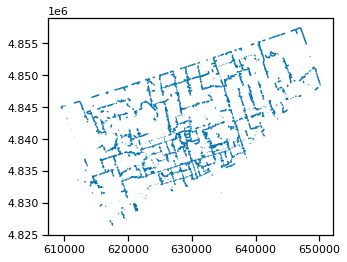

In [10]:
neigh_merge[neigh_merge['AREA_NAME'] == 'None'].plot()

#### Look at K-Mean Clustering of roads in Toronto
This is one option of splitting the data instead of doing Kfolds on the neighbourhoods. <br>
Not every road segment is in a neighbourhood, and 141 neighbourhoods is a lot of KFolds to evaluate

In [15]:
# Import clustering algorithm
from sklearn.cluster import KMeans

<AxesSubplot:>

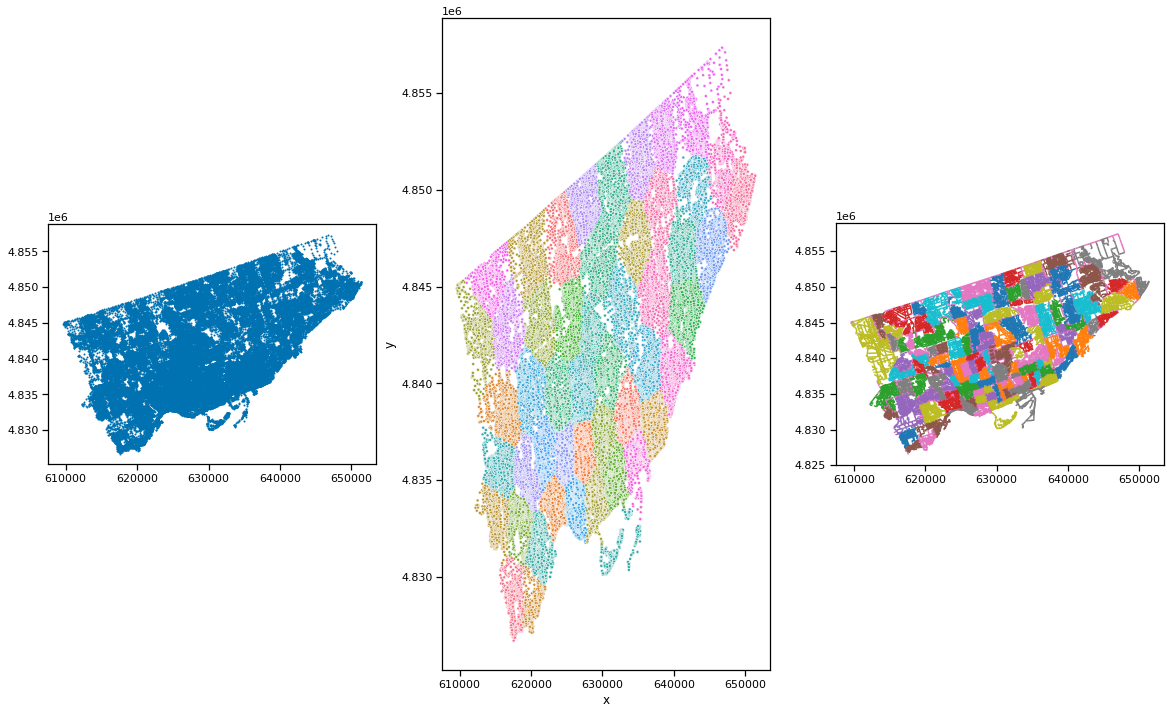

In [21]:
# Import data
centroids = lts_metre['geometry'].centroid
centroids_df = pd.DataFrame(data={'x':centroids.x, 'y':centroids.y})

# Define algorithm and cluster
kmeans = KMeans(n_clusters=50)
kmeans.fit(centroids_df)

# Plot the clusters
fig, ax = plt.subplots(ncols=3, figsize=(20,12))
centroids.plot(ax=ax[0], markersize=1)
sns.scatterplot(ax=ax[1], x=centroids_df['x'], y=centroids_df['y'], hue=kmeans.labels_.astype(str), legend=False, marker='.')
neigh_merge.plot(ax=ax[2], column='AREA_NAME')

#### Use "GroupKFold" from scikit learn to create the spatial kfold
Found this here https://towardsdatascience.com/spatial-cross-validation-using-scikit-learn-74cb8ffe0ab9

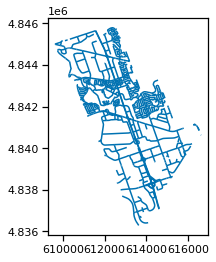

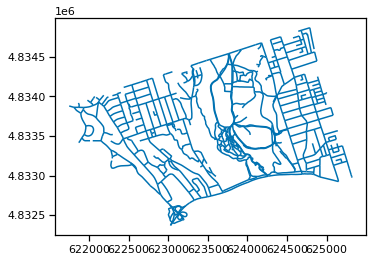

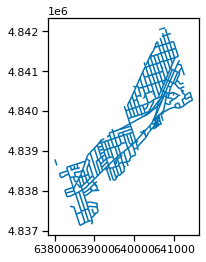

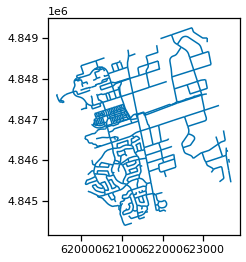

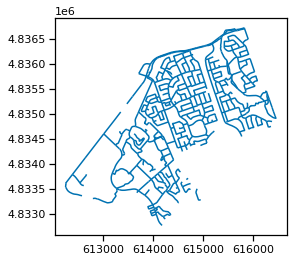

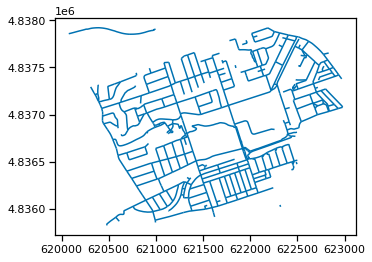

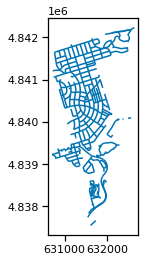

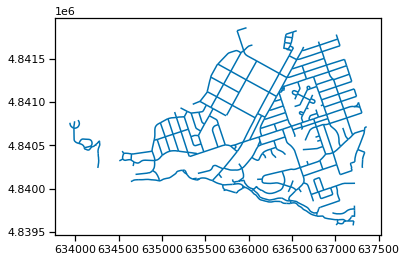

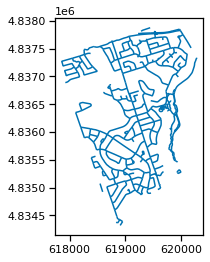

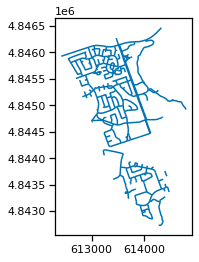

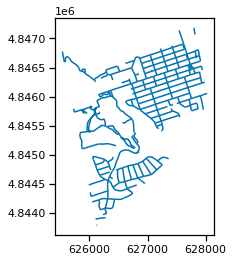

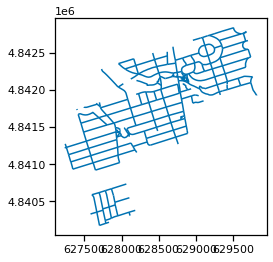

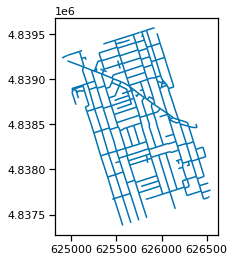

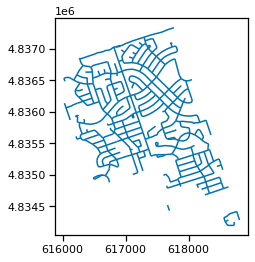

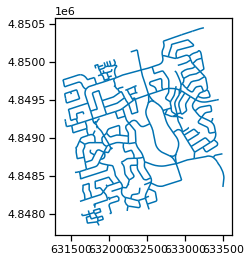

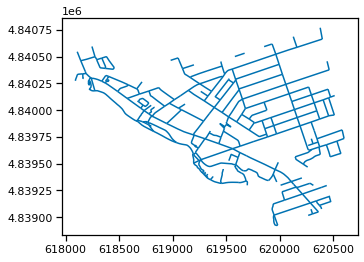

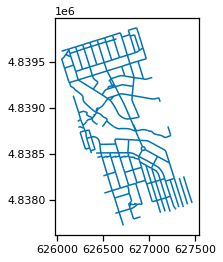

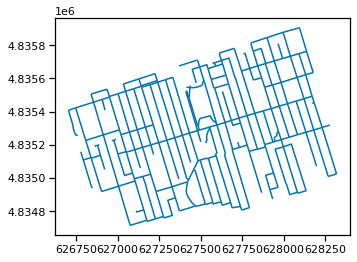

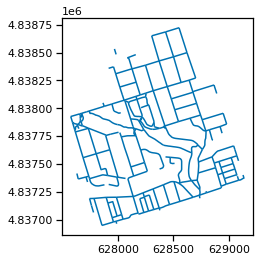

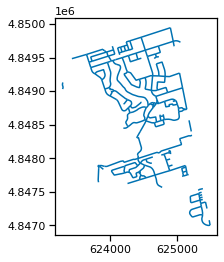

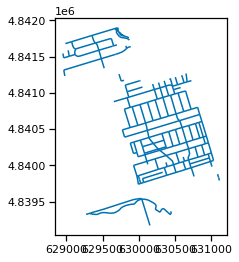

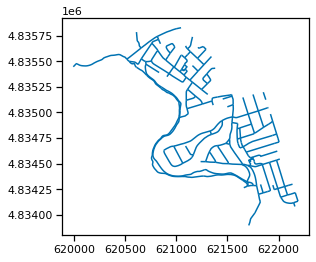

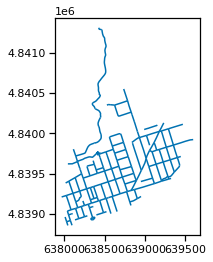

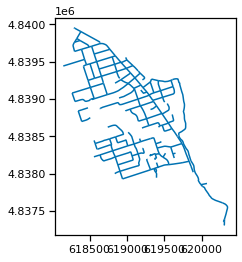

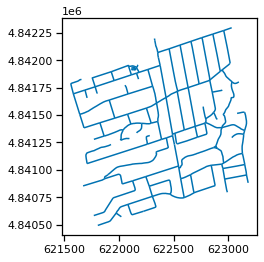

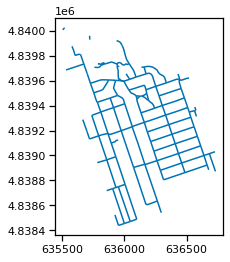

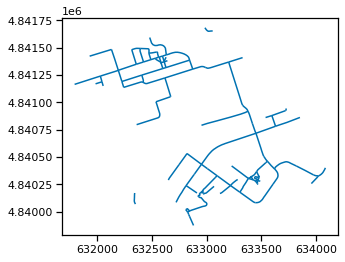

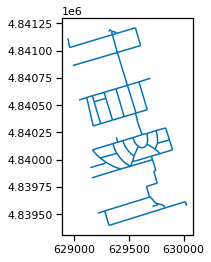

In [71]:
from sklearn.model_selection import GroupKFold, cross_val_score

def spatial_cv(model, grouper, splits, X, y):
    """
    Function performs spatial Cross Val based on the past grouping labels.
    
    model = sklearn model to be fit.
    grouper = labels in the data's index order of spatial k-folds (ex. neighbourhood, clusters).
    data = data 
    """
    #Init the group Kfold with n splits.
    group_kfold = GroupKFold(n_splits=splits)
    
    i = 1
    
    f1s = []
    accs = []
    mse = []
    #Loop Through the train and val index, perform cv
    for train_index, val_index in group_kfold.split(X, y, grouper):
        
        # Fit model
        model.fit(X.iloc[train_index, :],
                  y.iloc[train_index])
        
        # Append scores for that loop
        f1s.append(f1_score(y.iloc[val_index],
                    model.predict(X.iloc[val_index, :]),
                    average='weighted'))
        
        accs.append(accuracy_score(y.iloc[val_index],
                    model.predict(X.iloc[val_index, :]),
                  ))
        
        mse.append(mean_squared_error(y.iloc[val_index],
                    model.predict(X.iloc[val_index, :]),
                  ))
        
    #Print the results
    print('Mean fold weighted F1 Score: {}'.format(np.mean(f1s)))
    print('Mean fold accuracy Score: {}'.format(np.mean(accs)))
    print('Mean fold MSE: {}'.format(np.mean(mse)))
    


#spatial_cv(neigh_merge['AREA_NAME'], 141, neigh_merge, neigh_merge)

This function works! Woohoo! but with 141 neighbourhoods, it will take forever to run. This might be where K means clustering of points has an advantage.